In [101]:
import csv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import re
import random
import json

from sklearn import datasets, model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize

# LOAD DATASET

In [102]:
dataset = []
cosset = []
c = 0
with open ('data2.csv') as csvfile:
    readCSV = csv.DictReader(csvfile, delimiter=',')
    for row in readCSV:
        rating = row['Rating']
        intent = ""
        if rating == "1" or rating == "2":
            intent = "Bad"
            dataset.append(
            {
                'review': row ['Review Text'],
                'intent': intent
            }
            )
        elif rating == "4" or rating == "5" or rating == "3":
            intent = "Good"
            dataset.append(
            {
                'review': row ['Review Text'],
                'intent': intent
            }
          )
            
            
            
#Remove review text without rating
for row in dataset:
    if row['review'] == '' or row['intent'] == '':
        dataset.remove(row)
        
print(len(dataset))
print(dataset[1])

22674
{'review': 'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.', 'intent': 'Good'}


# Preprocessing

In [2]:
stop_words = set(stopwords.words('english'))
ps = PorterStemmer()

def preprocessing(dataset):
    for row in dataset:
        row['review'] = row['review'].casefold()
        row['review'] = re.sub('[^A-Za-z0-9 ]+','', row['review'])

        word_tokens = word_tokenize(row['review']) 

        filtered_sentence = [w for w in word_tokens if not w in stop_words]

        for w in word_tokens: 
            if w not in stop_words: 
                filtered_sentence.append(w)

        row['review'] = " ".join(filtered_sentence)

        stop_sentence = [] 

        for v in filtered_sentence:
            stop_sentence.append(ps.stem(v))

        row['review'] = " ".join(stop_sentence)
        

preprocessing(dataset)

NameError: name 'PorterStemmer' is not defined

In [104]:
dataset[1]

{'intent': 'Good',
 'review': 'love dress sooo pretti happen find store im glad bc never would order onlin bc petit bought petit 58 love length hit littl knee would definit true midi someon truli petit love dress sooo pretti happen find store im glad bc never would order onlin bc petit bought petit 58 love length hit littl knee would definit true midi someon truli petit'}

# Create Json File

In [105]:
with open('dataset.json', 'w') as outfile:
    json.dump(dataset, outfile)

# SPLIT DATASET

In [106]:
from sklearn.model_selection import train_test_split
datatrain, datatest = train_test_split(dataset, test_size=0.4, random_state=40)

# Bag of Words


In [200]:
vect = CountVectorizer()
xtrain_counts = vect.fit_transform([x['review'] for x in datatrain])
xtrain_counts.shape


(13604, 12367)

In [108]:
xtrain_tfidf = TfidfTransformer().fit_transform(xtrain_counts)
xtrain_tfidf.shape


(13604, 12367)

# TRAINING USING SGDCLASSIFIER

In [109]:
text_clf_sgd = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                            alpha=1e-3, max_iter=50, random_state=42)),])

_ = text_clf_sgd.fit([row['review'] for row in datatrain], [row['intent'] for row in datatrain])

predicted_sgd = text_clf_sgd.predict([row['review'] for row in datatest])
np.mean(predicted_sgd == [row['intent'] for row in datatest])

0.896141124586549

# Result SGD

In [110]:
y_true = [row['intent'] for row in datatest]
y_pred = predicted_sgd
precision_recall_fscore_support(y_true, y_pred, average='macro')

D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.4480705622932745, 0.5, 0.4726130945458774, None)

# TRAINING USING SVM

In [214]:
text_clf_svm = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf-svm', SVC(C=1.0, kernel='linear', gamma=0.5,probability=True)),])

text_clf_svm = text_clf_svm.fit([row['review'] for row in datatrain], [row['intent'] for row in datatrain])

predicted_svm = text_clf_svm.predict(row['review'] for row in datatest)
np.mean(predicted_svm == [row['intent'] for row in datatest])

0.9117971334068358

# Result

In [112]:
y_true = [row['intent'] for row in datatest]
y_pred = predicted_svm
precision_recall_fscore_support(y_true, y_pred, average='macro')

(0.7929645528284, 0.6452927522694217, 0.6866952026196012, None)

# TRAINING USING NAIVE BAYES

In [113]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(xtrain_tfidf, [row['intent'] for row in datatrain])
text_clf_bayes = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB()),])

text_clf_bayes = text_clf_bayes.fit([row['review'] for row in datatrain], [row['intent'] for row in datatrain])

predicted_bayes = text_clf_bayes.predict([row['review'] for row in datatest])
np.mean(predicted_bayes == [row['intent'] for row in datatest])

0.896141124586549

# Result

In [114]:
y_true = [row['intent'] for row in datatest]
y_pred = predicted_bayes
precision_recall_fscore_support(y_true, y_pred, average='macro')

D:\anaconda\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.4480705622932745, 0.5, 0.4726130945458774, None)

In [115]:
from sklearn.neighbors import KNeighborsClassifier

text_clf_knn = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf',  KNeighborsClassifier(n_neighbors=3)),])

text_clf_knn = text_clf_knn.fit([row['review'] for row in datatrain], [row['intent'] for row in datatrain])

predicted_knn = text_clf_knn.predict([row['review'] for row in datatest])
np.mean(predicted_knn == [row['intent'] for row in datatest])

0.896141124586549

# Logistic Regression

In [116]:
text_clf_LR = Pipeline([('vect', CountVectorizer()),
                        ('tfidf', TfidfTransformer()),
                        ('clf', LogisticRegression(C=0.2, dual=True)),])

text_clf_LR = text_clf_LR.fit([row['review'] for row in datatrain], [row['intent'] for row in datatrain])

predicted_LR = text_clf_LR.predict([row['review'] for row in datatest])
np.mean(predicted_LR == [row['intent'] for row in datatest])

0.8972436604189636

# Result

In [125]:
#PREPROCESS INPUT
def preprocessing_input(input_text):
    input_text = input_text.casefold()
    input_text = re.sub('[^A-Za-z0-9 ]+','', input_text)
    filtered_sentence = []
    word_tokens = word_tokenize(input_text) 
    for w in word_tokens: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    input_text= " ".join(filtered_sentence)
    
    return input_text


In [182]:
#Predict
def predict_input(input_text):
    print("After preprocessing : ",preprocessing_input(input_text))
    pred = text_clf_svm.predict([preprocessing_input(input_text)])
    decision = text_clf_svm.predict_proba([preprocessing_input(input_text)])
    print()
    print("Result : " ,pred)
    print("---Bad---- ","---Good---")
    print(decision)
    result = pred 
    result = str("Predicted as ") + str(result) + str(" review with probability ")+ str(" Bad / Good : ") + str(decision)
   
    return result

In [183]:
predict_input("very bad product, uncomfortable, too cheap")

After preprocessing :  bad product uncomfortable cheap

Result :  ['Bad']
---Bad----  ---Good---
[[0.97398182 0.02601818]]


"Predicted as ['Bad'] review with probability  Bad / Good : [[0.97398182 0.02601818]]"

In [184]:
#GETTING INTENT
input = "very bad product, uncomfortable, too cheap"
preprocess_input = chat_input(input)
print("Before preprocessing : ",input)
print()
print("After preprocessing : ",preprocess_input)
pred = text_clf_svm.predict([preprocess_input])
decision = text_clf_svm.predict_proba([preprocess_input])
print()
print("Result : " ,pred)
print("---Bad---- ","---Good---")
print(decision)

Before preprocessing :  very bad product, uncomfortable, too cheap

After preprocessing :  bad product uncomfortable cheap

Result :  ['Bad']
---Bad----  ---Good---
[[0.97398182 0.02601818]]


In [134]:
import pickle

with open('model_svm','wb') as file:
    pickle.dump(text_clf_svm,file)

In [185]:
for row in dataset:
    if row['intent'] == 'Baad':
        print(row)

In [ ]:
neg_tweets = df[df.Rating == 1] 
neg_string = []

for t in neg_tweets['Review Text']:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

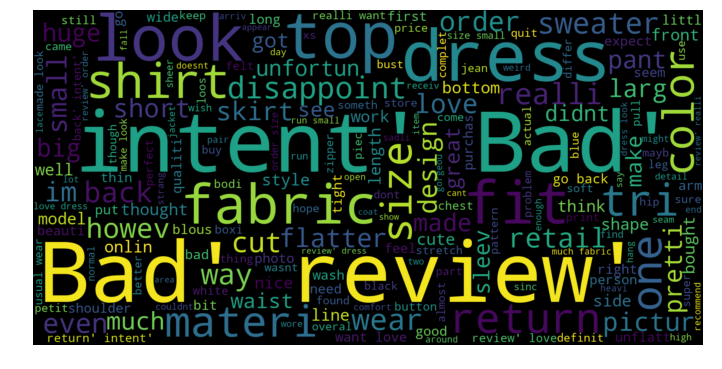

In [194]:
neg_review = []
neg_string = []

for row in dataset:
    if row['intent'] == 'Bad':
        neg_review.append(row)

for x in neg_review:
    neg_string.append(x)
neg_string = str(neg_string)
len(neg_review)

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

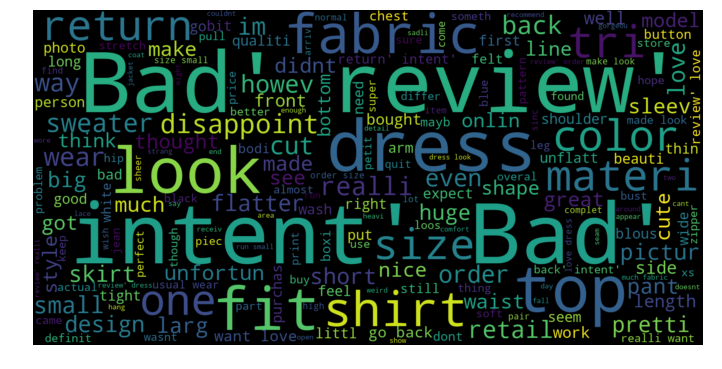

In [195]:
pos_review = []
pos_string = []

for row in dataset:
    if row['intent'] == 'Good':
        pos_review.append(row)

for x in neg_review:
    pos_string.append(x)
pos_string = str(pos_string)
len(pos_review)

from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()